In [20]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import matplotlib
%matplotlib inline

from itertools import permutations
from math import sin, cos, pi, sqrt

from tqdm import tqdm

from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [45]:
plt.rcParams.update({'font.size': 20})

In [3]:
def parity_shell(values):
    values = list(values)
    N = len(values)
    num_swaps = 0
    for i in range(N-1):
        for j in range(i+1, N):
            if values[i] > values[j]:
                values[i], values[j] = values[j], values[i]
                num_swaps += 1
    return num_swaps % 2

def calculate_S_array(centre_list, r):
    S_arr = []

    x_r1 = np.array([r, 0, 0, 0.5*(r**2 - 1), 0.5*(r**2 + 1)])
    x_r2 = np.array([0, r, 0, 0.5*(r**2 - 1), 0.5*(r**2 + 1)])
    x_r3 = np.array([0, 0, r, 0.5*(r**2 - 1), 0.5*(r**2 + 1)])
    x_r4 = np.array([-r, 0, 0, 0.5*(r**2 - 1), 0.5*(r**2 + 1)])

    for x_c, y_c, z_c in centre_list:
        dist_sq = x_c**2 + y_c**2 + z_c**2
        #dist_sq = 1
        x_center = np.array([x_c, y_c, z_c, 0.5*(dist_sq - 1), 0.5*(dist_sq + 1)])

        x_1 = x_center + x_r1
        x_2 = x_center + x_r2
        x_3 = x_center + x_r3
        x_4 = x_center + x_r4

        S = np.array([0, 0, 0, 0, 0])
        res1 = 0
        res2 = 0
        res3 = 0
        res4 = 0
        res5 = 0
        for perm in list(permutations([1, 2, 3, 4])):
            res1 += ((-2)*parity_shell(perm) + 1)*x_1[perm[0]]*x_2[perm[1]]*x_3[perm[2]]*x_4[perm[3]]
        for perm in list(permutations([0, 2, 3, 4])):
            res2 += ((-2)*parity_shell(perm) + 1)*x_1[perm[0]]*x_2[perm[1]]*x_3[perm[2]]*x_4[perm[3]]
        for perm in list(permutations([0, 1, 3, 4])):
            res3 += ((-2)*parity_shell(perm) + 1)*x_1[perm[0]]*x_2[perm[1]]*x_3[perm[2]]*x_4[perm[3]]
        for perm in list(permutations([0, 1, 2, 4])):
            res4 += ((-2)*parity_shell(perm) + 1)*x_1[perm[0]]*x_2[perm[1]]*x_3[perm[2]]*x_4[perm[3]]
        for perm in list(permutations([0, 1, 2, 3])):
            res5 += ((-2)*parity_shell(perm) + 1)*x_1[perm[0]]*x_2[perm[1]]*x_3[perm[2]]*x_4[perm[3]]

        S = np.array([res1, res2, res3, res4, res5])

        S_arr.append(S)

    return np.array(S_arr)

In [195]:
def A_default(u):
    A_default = np.zeros((u, u))
    for i in range(u):
        for j in range(u):
            if i < j:
                A_default[i][j] = 1
    return A_default

def calculate_hyperfield_V(data, m, prediction_window = 10, u = 10, r = 0.1, A = 'default', extend = False):
    
    if A == 'default':
        A = np.zeros((u, u))
        for i in range(u):
            for j in range(u):
                if i < j:
                    A[i][j] = 1
    
    centre_list = []
    for k in range(u):
        centre_list.append((cos(2*pi*k/u), sin(2*pi*k/u), 0))
    
    S_array = calculate_S_array(centre_list, r)
    
    V_final_array = []
    
    if extend == True:
        l = list(data)
        l.extend([0]*u)
        data = np.array(l)
    
    for w in range(1, prediction_window + 1):
        
        V_array = []
        time_array = []
        
        if extend == False:
            modified_data = np.flip(data[np.arange(m + w, -1, -w)])
            original_index = np.flip(np.arange(len(data))[np.arange(m + w, -1, -w)])
        else:
            modified_data = np.flip(data[np.arange(m + 2*w, -1, -w)])
            original_index = np.flip(np.arange(len(data))[np.arange(m + 2*w, -1, -w)])
        
        for i in range(len(modified_data) - u):
            
            alpha = modified_data[i:(i+u)]
            Omega = np.array([alpha[i]*S_array[i] for i in range(u)])
            V_N = np.sum(Omega, axis = 0)
            V_AN = np.sum(np.array([[Omega[i]*Omega[j]*A[i][j] for j in range(u)] for i in range(u)]), axis = (0, 1, 2))
            V = np.hstack((V_N, V_AN))
            
            V_array.append(V)
            time_array.append(original_index[i+u])
        
        V_final_array.append((V_array, time_array))
        
    return V_final_array

In [118]:
def calculate_emergent_hyperfields_S(V_array, L_1 = 5, L_2 = 10):
    
    S_array = []
    
    for V_arr, _ in V_array:
        
        S_1_arr = [np.zeros((6,))]*L_1
        S_2_arr = [np.zeros((6,))]*(L_1 + 1)
        S_3_arr = [np.zeros((6,))]*L_2
        
        for i in range(L_1, len(V_arr)):
            S_1_arr.append(V_arr[i] - 1/L_1 * (np.sum(V_arr[(i - L_1):i], axis = 0)))
        for i in range(L_1 + 1, len(V_arr)):
            S_2_arr.append(S_1_arr[i] - S_1_arr[i - 1])
        for i in range(L_2, len(V_arr)):
            S_3_arr.append(V_arr[i] - 1/L_2 * (np.sum(V_arr[(i - L_2):i], axis = 0)))
            
        S_array.append((S_1_arr, S_2_arr, S_3_arr))
    
    return S_array

In [200]:
#eps = 10
#def target_func(data, index, w):
#    return (data[index] - data[index - w])/(data[index - w] + eps)

def target_func(data, index, w):
    return data[index]

def combine_hyperfields_for_single_series(data, V_array, S_array, L_1 = 5, L_2 = 10):
    
    L = max(L_1, L_2)
    
    train_test_data_features = []
    train_test_data_targets = []
    
    sizes = []
    
    validation_data_features = []
    validation_data_targets = []
    
    for i, arrs in enumerate(zip(V_array, S_array)):
        
        V_arr, S_arr = arrs
        w = i + 1
        features = []
        targets = []
        
        for j in range(L, len(V_arr[0]) - 1):
            features.append(np.array([np.sum(V_arr[0][j]),np.sum(S_arr[0][j]), np.sum(S_arr[1][j]), np.sum(S_arr[2][j])]))
            targets.append(target_func(data, V_arr[1][j], w))
        
        train_test_data_features.extend(features)
        train_test_data_targets.extend(targets)
        
        sizes.append(len(features))
        
        validation_data_features.append(np.array([np.sum(V_arr[0][-1]),np.sum(S_arr[0][-1]), np.sum(S_arr[1][-1]), \
                                                         np.sum(S_arr[2][-1])]))
        validation_data_targets.append(target_func(data, V_arr[1][-1], w))
    
    return (np.array(train_test_data_features), np.array(train_test_data_targets)), \
            (np.array(validation_data_features), np.array(validation_data_targets)), sizes



def combine_hyperfields_for_two_series(data_1, data_2, V_array_1, S_array_1, V_array_2, S_array_2, L_1 = 5, L_2 = 10):
    
    L = max(L_1, L_2)
    
    train_test_data_features = []
    train_test_data_targets = []
    
    sizes = []
    
    validation_data_features = []
    validation_data_targets = []
    
    for i, arrs in enumerate(zip(V_array_1, S_array_1, V_array_2, S_array_2)):
        
        V_arr_1, S_arr_1, V_arr_2, S_arr_2 = arrs
        w = i + 1
        features = []
        targets = []
        
        for j in range(L, len(V_arr_1[0]) - 1):
            features_list = []
            features_list += [np.sum(V_arr_1[0][j]),np.sum(S_arr_1[0][j]), np.sum(S_arr_1[1][j]), np.sum(S_arr_1[2][j])]
            features_list += [np.sum(V_arr_2[0][j]),np.sum(S_arr_2[0][j]), np.sum(S_arr_2[1][j]), np.sum(S_arr_2[2][j])]
            features_list += [np.sum(V_arr_2[0][j+1]),np.sum(S_arr_2[0][j+1]), np.sum(S_arr_2[1][j+1]), np.sum(S_arr_2[2][j+1])]
            features.append(np.array(features_list))
            targets.append(target_func(data_1, V_arr_1[1][j], w))
        
        train_test_data_features.extend(features)
        train_test_data_targets.extend(targets)
        
        sizes.append(len(features))
        
        validation_data_feature_list = [np.sum(V_arr_1[0][-1]),np.sum(S_arr_1[0][-1]), \
                                        np.sum(S_arr_1[1][-1]), np.sum(S_arr_1[2][-1])]
        validation_data_feature_list += [np.sum(V_arr_2[0][-2]),np.sum(S_arr_2[0][-2]), \
                                        np.sum(S_arr_2[1][-2]), np.sum(S_arr_2[2][-2])]
        validation_data_feature_list += [np.sum(V_arr_2[0][-1]),np.sum(S_arr_2[0][-1]), \
                                        np.sum(S_arr_2[1][-1]), np.sum(S_arr_2[2][-1])]
        
        
        validation_data_features.append(np.array(validation_data_feature_list))
        validation_data_targets.append(target_func(data_1, V_arr_1[1][-1], w))
    
    return (np.array(train_test_data_features), np.array(train_test_data_targets)), \
            (np.array(validation_data_features), np.array(validation_data_targets)), sizes

In [198]:
def generate_STON_based_dataset_for_single_series(data, m, prediction_window = 10, u = 10, r = 0.1, A = 'default', \
                                                  L_1 = 5, L_2 = 10):
    V_array = calculate_hyperfield_V(data = data, m = m, prediction_window = prediction_window, u = u, r = r, A = A)
    S_array = calculate_emergent_hyperfields_S(V_array = V_array, L_1 = L_1, L_2 = L_2)
    train_test_data, validation_data, sizes = combine_hyperfields_for_single_series(data = data, V_array = V_array, \
                                                                                    S_array = S_array, L_1 = L_1, L_2 = L_2)
    return train_test_data, validation_data, sizes


def generate_STON_based_dataset_for_two_series(data_1, data_2, m, prediction_window = 10, u = 10, r = 0.1, A = 'default', \
                                                  L_1 = 5, L_2 = 10):
    V_array_1 = calculate_hyperfield_V(data = data_1, m = m, prediction_window = prediction_window, u = u, r = r, A = A)
    S_array_1 = calculate_emergent_hyperfields_S(V_array = V_array_1, L_1 = L_1, L_2 = L_2)
    
    
    V_array_2 = calculate_hyperfield_V(data = data_2, m = m, prediction_window = prediction_window, u = u, r = r, A = A,\
                                       extend = True)
    S_array_2 = calculate_emergent_hyperfields_S(V_array = V_array_2, L_1 = L_1, L_2 = L_2)
    
    train_test_data, validation_data, sizes = combine_hyperfields_for_two_series(data_1, data_2, V_array_1, S_array_1, \
                                                                                 V_array_2, S_array_2, L_1 = L_1, L_2 = L_2)
    return train_test_data, validation_data, sizes

In [207]:
def visualize_hyperfields(train_test_data_features, sizes, w = 1, extended = False):
    
    if w == 1:
        a = 0
        b = sizes[0]
    else:
        a = np.sum(sizes[:(w-2 + 1)])
        b = np.sum(sizes[:(w-1 + 1)])
    
    if extended == False:
        fig, axes = plt.subplots(2, 2, figsize = (20, 20))

        axes[0][0].plot(train_test_data_features[a:b, 0])
        axes[0][1].plot(train_test_data_features[a:b, 1])
        axes[1][0].plot(train_test_data_features[a:b, 2])
        axes[1][1].plot(train_test_data_features[a:b, 3])

        axes[0][0].set_ylabel('$||V^{}||$'.format(w))
        axes[0][1].set_ylabel('$||S^{}_1||$'.format(w))
        axes[1][0].set_ylabel('$||S^{}_2||$'.format(w))
        axes[1][1].set_ylabel('$||S^{}_3||$'.format(w))
    
    else:
        fig, axes = plt.subplots(4, 2, figsize = (20, 40))

        axes[0][0].plot(train_test_data_features[a:b, 0])
        axes[0][1].plot(train_test_data_features[a:b, 1])
        axes[1][0].plot(train_test_data_features[a:b, 2])
        axes[1][1].plot(train_test_data_features[a:b, 3])
        
        axes[2][0].plot(train_test_data_features[a:b, 4])
        axes[2][1].plot(train_test_data_features[a:b, 5])
        axes[3][0].plot(train_test_data_features[a:b, 6])
        axes[3][1].plot(train_test_data_features[a:b, 7])
        

        axes[0][0].set_ylabel('$||V^{}||$, ряд 1'.format(w))
        axes[0][1].set_ylabel('$||S^{}_1||$, ряд 1'.format(w))
        axes[1][0].set_ylabel('$||S^{}_2||$, ряд 1'.format(w))
        axes[1][1].set_ylabel('$||S^{}_3||$, ряд 1'.format(w))
        
        axes[2][0].set_ylabel('$||V^{}||$, ряд 2'.format(w))
        axes[2][1].set_ylabel('$||S^{}_1||$, ряд 2'.format(w))
        axes[3][0].set_ylabel('$||S^{}_2||$, ряд 2'.format(w))
        axes[3][1].set_ylabel('$||S^{}_3||$, ряд 2'.format(w))
    
    plt.show()

In [232]:
df = pd.read_csv("monthly_sunspots.csv")
df.head()

,Month,Sunspots
0,1749-01,58.0
1,1749-02,62.6
2,1749-03,70.0
3,1749-04,55.7
4,1749-05,85.0


In [233]:
raw_data = df['Sunspots'].to_numpy()
raw_data.shape

(2820,)

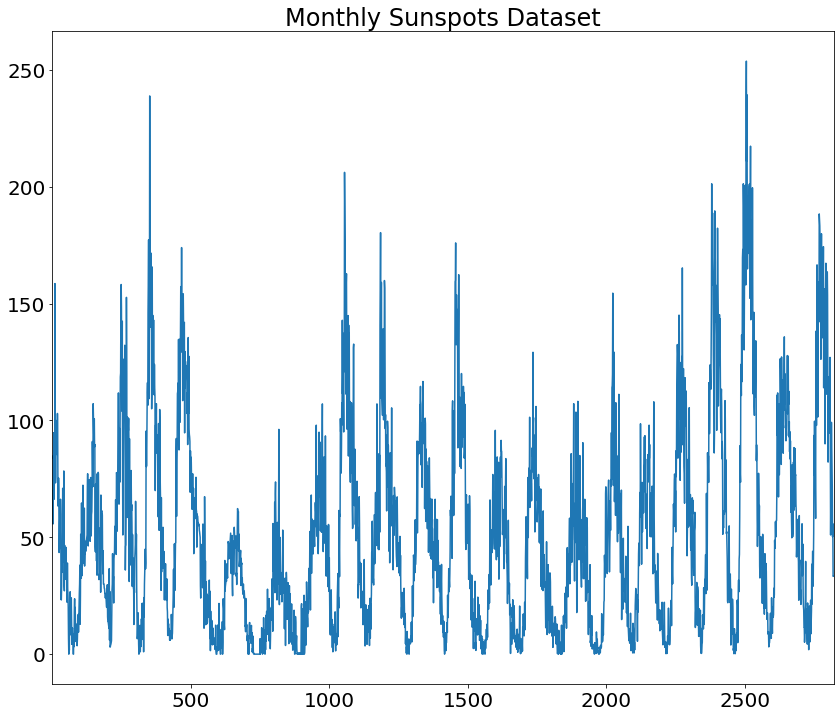

In [234]:
plt.figure(figsize = (14, 12))
plt.plot(raw_data)
plt.title('Monthly Sunspots Dataset')
plt.xlim(1, 2820)
plt.show()

In [236]:
m = 2809

In [237]:
train_test_data, validation_data, sizes = generate_STON_based_dataset_for_single_series(raw_data, m = m, \
                                                                      prediction_window = 10, u = 10, r = 0.09)

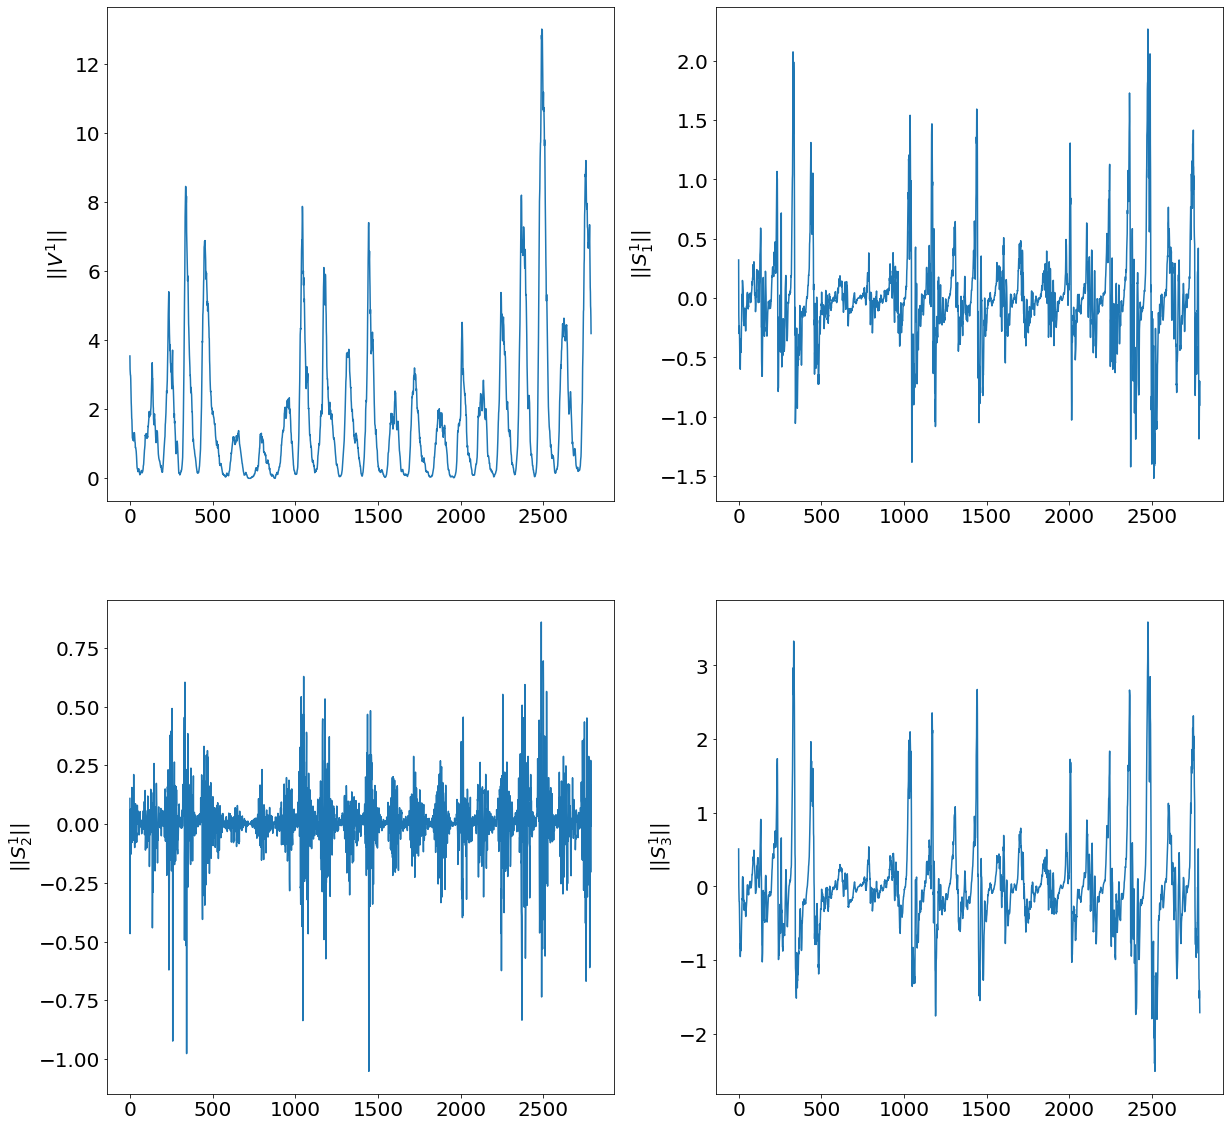

In [238]:
visualize_hyperfields(train_test_data[0], sizes, w = 1)

In [141]:
class TimeSeriesDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]
    

class FullyConnectedMLP(nn.Module):
    def __init__(self, input_shape, hiddens, output_shape):
        assert isinstance(hiddens, list)
        super().__init__()
        self.input_shape = (input_shape,)
        self.output_shape = (output_shape,)
        self.hiddens = hiddens

        # Stack some fully connected layers wirh relu activation.
        # Note that you do not have to add relu after the last fc layer
        
        model = []
        for i in range(len(hiddens)):
            if i == 0:
                model += [nn.Linear(input_shape, hiddens[i])]
            else:
                model += [nn.Linear(hiddens[i-1], hiddens[i])]
            model += [nn.ReLU()]
        
        model += [nn.Linear(hiddens[-1], output_shape)]
        self.net = nn.Sequential(*model)

    def forward(self, x):
        return self.net(x)

In [142]:
BATCH_SIZE = 4
EPOCHS = 25
LR = 10*1e-3

In [143]:
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"
    
device = torch.device(device)

In [144]:
device

device(type='cuda', index=0)

In [145]:
def train_epoch(model, train_loader, optimizer, loss, verbose = False):
    model.train()
    losses_array = []
    for batch in tqdm(train_loader, disable = not verbose):
        x, y = batch
        losses = loss(model(x.float().to(device)).flatten(), y.float().to(device))
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        losses_array.append(losses)
    return losses_array

def eval_model(model, test_loader, loss):
    model.eval()
    losses_array = []
    with torch.no_grad():
        for batch in test_loader:
            x, y = batch
            losses = loss(model(x.float().to(device)).flatten(), y.float().to(device))
            losses_array.append(losses)
            
    return losses_array


def train_model(model, train_loader, test_loader, batch_size, epochs, lr, verbose = False, extra_verbose = False):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    loss = nn.L1Loss()

    train_losses = []
    test_losses = []
    
    i = 1
    
    for epoch in tqdm(range(epochs), disable = verbose):
        train_loss = train_epoch(model, train_loader, optimizer, loss = loss, verbose = extra_verbose)
        test_loss = eval_model(model, test_loader, loss = loss)
        
        if (verbose == True):
            print('Epoch {}: Test loss = {}'.format(i, torch.Tensor(test_loss).mean().cpu().detach().numpy()))
        
        i += 1
        
        train_losses.append(torch.Tensor(train_loss).cpu().detach().numpy().mean())
        test_losses.append(torch.Tensor(test_loss).cpu().detach().numpy().mean())

    return np.array(train_losses), np.array(test_losses)

In [146]:
scaler = StandardScaler()
scaled_train_test_data = scaler.fit_transform(train_test_data[0])

train_test_dataset = TimeSeriesDataset(scaled_train_test_data, train_test_data[1])
#test_dataset = TimeSeriesDataset(test_data[0], test_data[1])

train_size = int(0.8 * len(train_test_dataset))
test_size = len(train_test_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(train_test_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle = True)

In [147]:
model = FullyConnectedMLP(4, [64, 128, 256, 128, 64], 1).to(device)
train_losses, test_losses = train_model(model, train_loader, test_loader, batch_size = BATCH_SIZE, epochs = EPOCHS, lr = LR, \
                                       verbose = False)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:50<00:00,  4.42s/it]


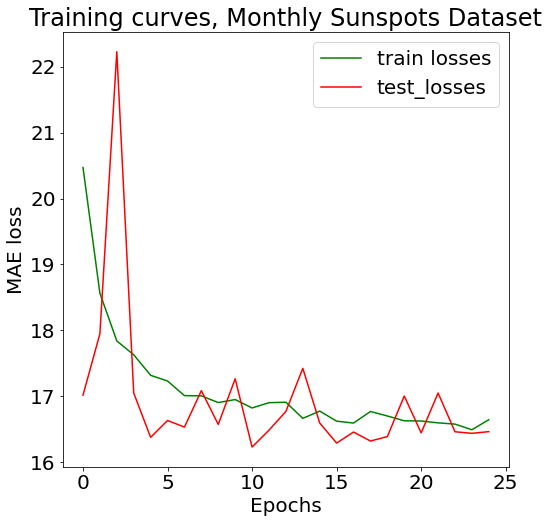

In [148]:
plt.figure(figsize = (8,8))

plt.plot(train_losses, label = 'train losses', color = 'green')
plt.plot(test_losses, label = 'test_losses', color = 'red')
plt.legend(loc = 'best')

plt.title('Training curves, Monthly Sunspots Dataset')

plt.xlabel('Epochs')
plt.ylabel('MAE loss')

plt.show()

In [31]:
def relative_to_abs(data, relative_prediction, m):
    return data[m]*(1 + relative_prediction + eps)

In [37]:
model.eval()
scaled_validation_data = scaler.transform(validation_data[0])
prediction_segment = torch.Tensor(scaled_validation_data).to(device)
absolute_prediction = model(prediction_segment).cpu().detach().numpy()
#absolute_prediction = relative_to_abs(raw_data, relative_prediction, m = m).flatten()

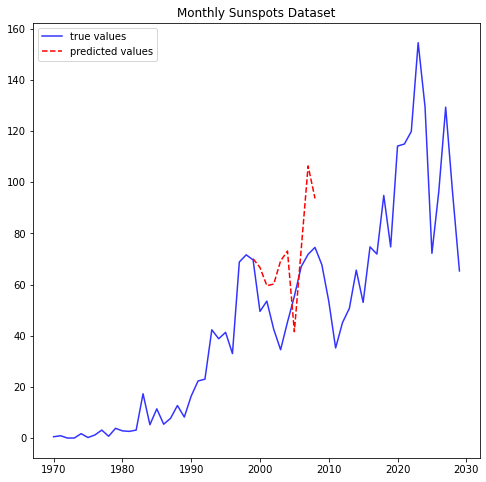

In [41]:
plt.figure(figsize = (8, 8))
plt.plot(np.arange(m+1-30, m+31), raw_data[(m+1-30): (m+31)], color = 'blue', alpha = 0.8, label = 'true values')
plt.plot(np.arange(m, m+10), absolute_prediction, '--', color = 'red', label = 'predicted values')
plt.title('Monthly Sunspots Dataset')

plt.legend(loc = 'best')
plt.show()

In [149]:
model.eval()
prediction_segment = torch.Tensor(scaled_train_test_data[:sizes[0]]).to(device)
absolute_prediction = model(prediction_segment).cpu().detach().numpy()

scaled_validation_data = scaler.transform(validation_data[0])
val_prediction_segment = torch.Tensor(scaled_validation_data).to(device)
val_absolute_prediction = model(val_prediction_segment).cpu().detach().numpy()

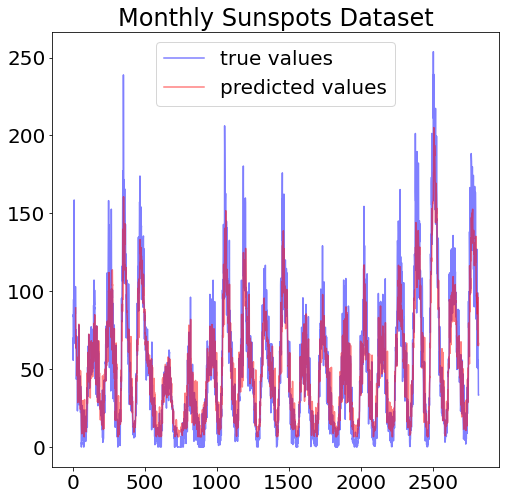

In [150]:
plt.figure(figsize = (8, 8))
plt.plot(raw_data, color = 'blue', label = 'true values', alpha = 0.5)
plt.plot(np.arange(m - sizes[0] + 1, m+1), absolute_prediction, color = 'red', label = 'predicted values', alpha = 0.5)
plt.plot(np.arange(m+1, m+11), val_absolute_prediction, color = 'red', alpha = 0.5)
plt.title('Monthly Sunspots Dataset')

plt.legend(loc = 'best')
plt.show()

In [153]:
df_sync = pd.read_csv('occupancy_data/datatraining.csv')
df_sync.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [154]:
raw_data_sync = df_sync[['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']].to_numpy()
raw_data_sync.shape

(8143, 5)

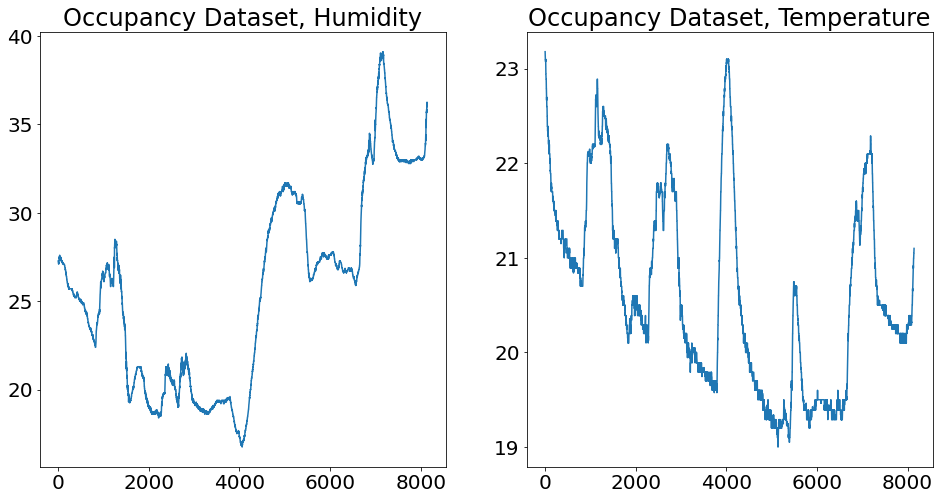

In [203]:
fig, axes = plt.subplots(1, 2, figsize = (16, 8))

axes[0].plot(raw_data_sync[:, 1])
axes[1].set_title('Occupancy Dataset, Temperature')
axes[1].plot(raw_data_sync[:, 0])
axes[0].set_title('Occupancy Dataset, Humidity')
plt.show()

In [179]:
sync_data_temp_hum = raw_data_sync[:, :2]
sync_data_temp = sync_data_temp_hum[:, 0]
sync_data_hum = sync_data_temp_hum[:, 1]

In [212]:
m = 8132
train_test_data, validation_data, sizes = generate_STON_based_dataset_for_single_series(sync_data_hum, m = m, \
                                                                      prediction_window = 10, u = 10, r = 0.09)

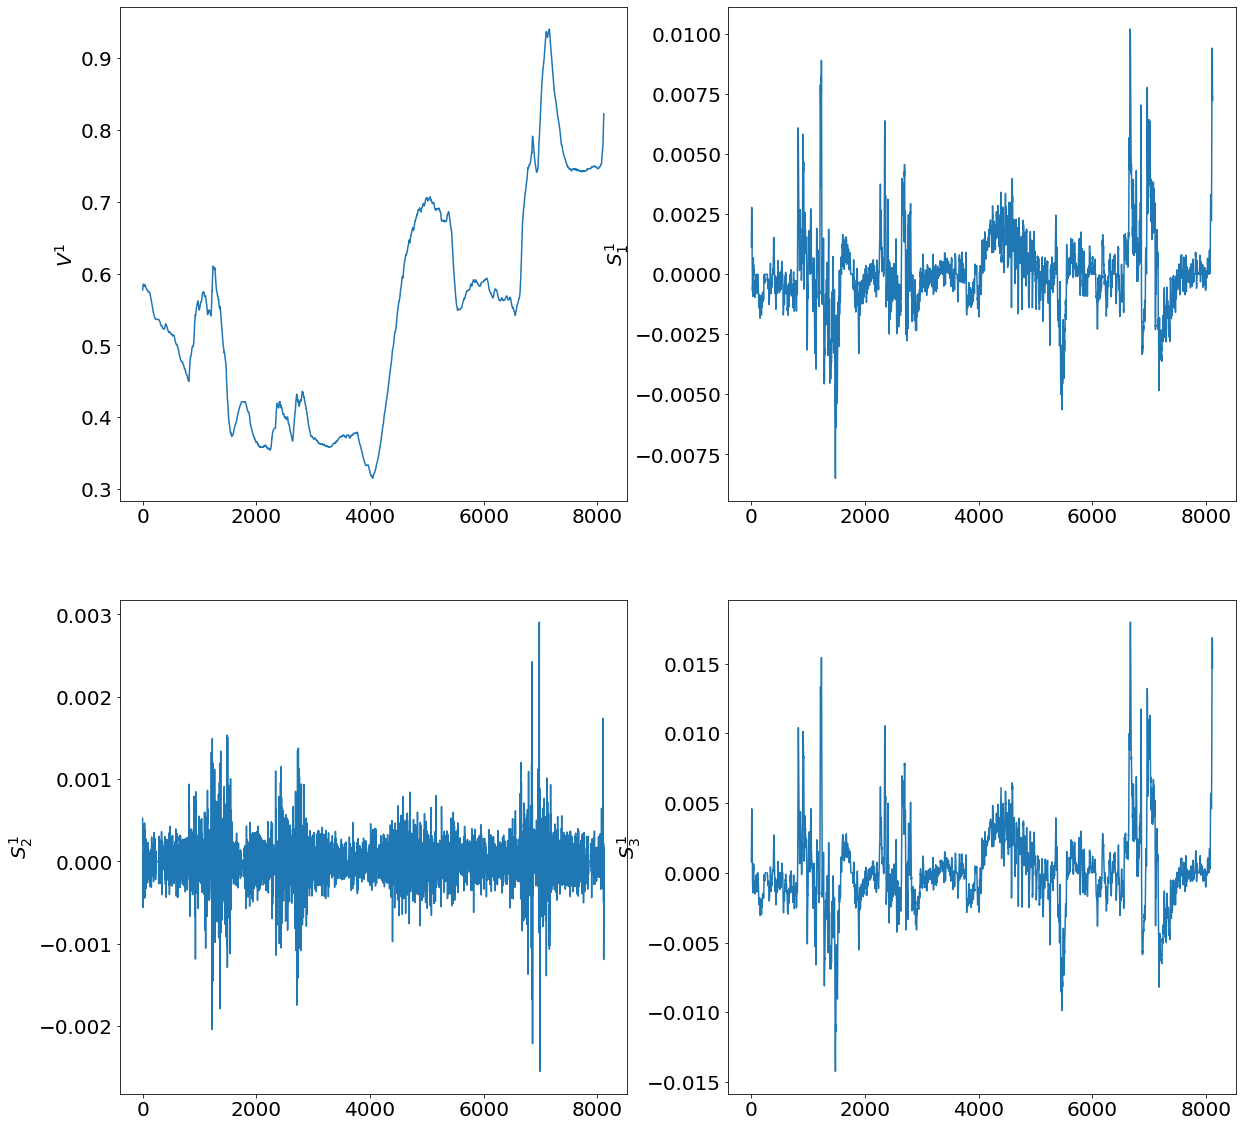

In [172]:
visualize_hyperfields(train_test_data[0], sizes, w = 1)

In [213]:
train_test_dataset = TimeSeriesDataset(train_test_data[0], train_test_data[1])

train_size = int(0.8 * len(train_test_dataset))
test_size = len(train_test_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(train_test_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle = True)

In [218]:
model = FullyConnectedMLP(4, [64, 128, 256, 128, 64], 1).to(device)
train_losses, test_losses = train_model(model, train_loader, test_loader, batch_size = BATCH_SIZE, epochs = EPOCHS, lr = LR, \
                                       verbose = False)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [05:27<00:00, 13.10s/it]


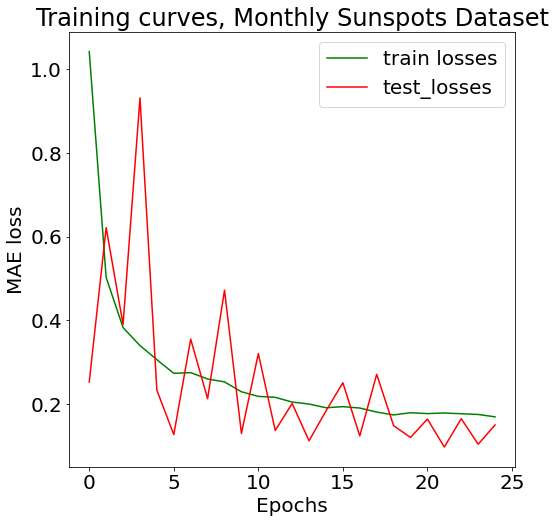

In [219]:
plt.figure(figsize = (8,8))

plt.plot(train_losses, label = 'train losses', color = 'green')
plt.plot(test_losses, label = 'test_losses', color = 'red')
plt.legend(loc = 'best')

plt.title('Training curves, Monthly Sunspots Dataset')

plt.xlabel('Epochs')
plt.ylabel('MAE loss')

plt.show()

In [221]:
model.eval()
prediction_segment = torch.Tensor(train_test_data[0][:sizes[0]]).to(device)
absolute_prediction = model(prediction_segment).cpu().detach().numpy()

val_prediction_segment = torch.Tensor(validation_data[0]).to(device)
val_absolute_prediction = model(val_prediction_segment).cpu().detach().numpy()

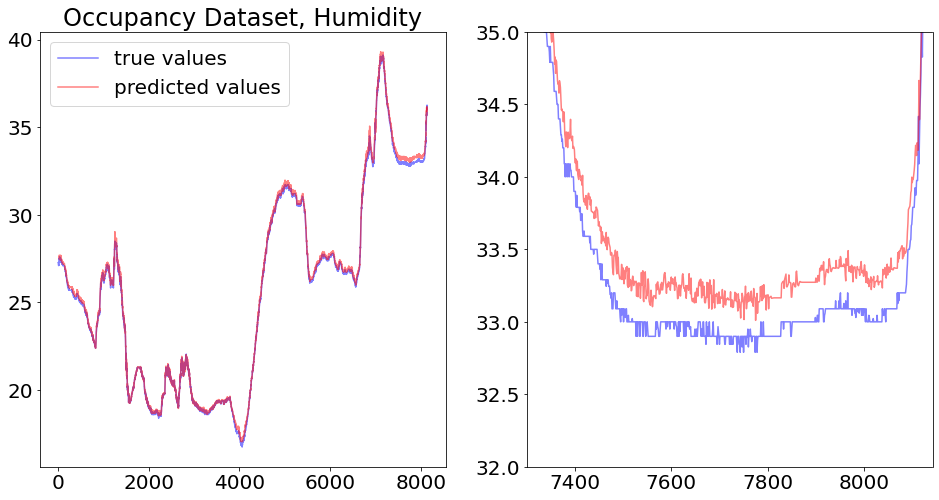

In [227]:
fig, axes = plt.subplots(1, 2, figsize = (16, 8))
axes[0].plot(sync_data_hum, color = 'blue', label = 'true values', alpha = 0.5)
axes[0].plot(np.arange(m - sizes[0] + 1, m+1), absolute_prediction, color = 'red', label = 'predicted values', alpha = 0.5)
axes[0].plot(np.arange(m+1, m+11), val_absolute_prediction, color = 'red', alpha = 0.5)
axes[0].set_title('Occupancy Dataset, Humidity')
axes[0].legend(loc = 'best')


axes[1].plot(sync_data_hum, color = 'blue', label = 'true values', alpha = 0.5)
axes[1].plot(np.arange(m - sizes[0] + 1, m+1), absolute_prediction, color = 'red', label = 'predicted values', alpha = 0.5)
axes[1].plot(np.arange(m+1, m+11), val_absolute_prediction, color = 'red', alpha = 0.5)
#axes[1].set_title('Occupancy Dataset, Humidity')
axes[0].legend(loc = 'best')
axes[1].set_ylim(32, 35)
axes[1].set_xlim(7300, 8142)
plt.show()

In [228]:
m = 8132
train_test_data, validation_data, sizes = generate_STON_based_dataset_for_two_series(sync_data_hum, sync_data_temp, m = m, \
                                                                      prediction_window = 10, u = 10, r = 0.09)

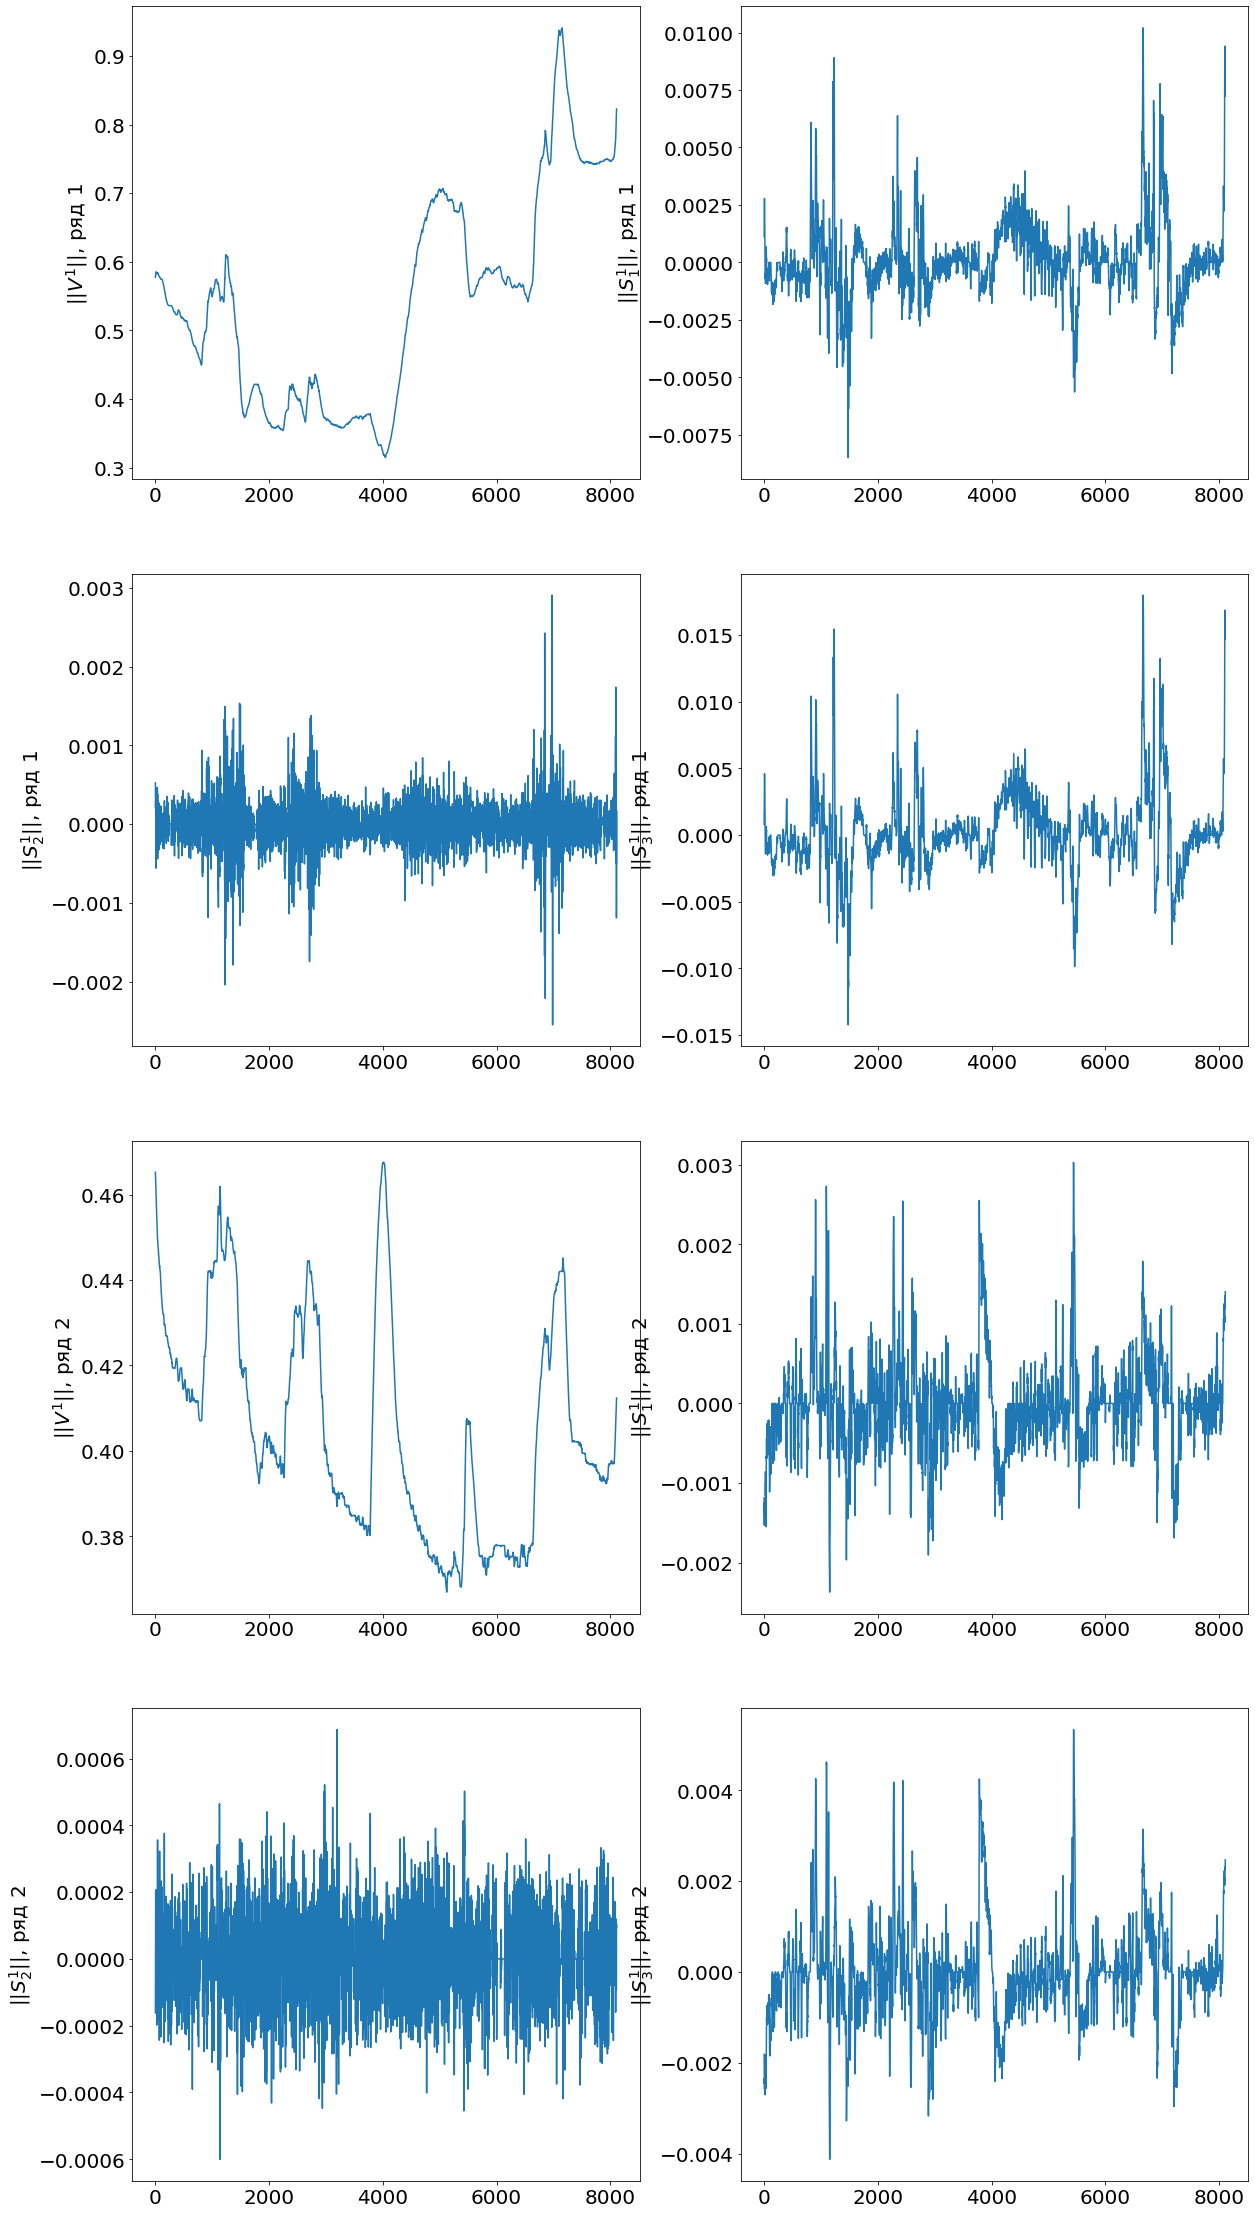

In [208]:
visualize_hyperfields(train_test_data[0], sizes, w = 1, extended = True)

In [229]:
train_test_dataset = TimeSeriesDataset(train_test_data[0], train_test_data[1])

train_size = int(0.8 * len(train_test_dataset))
test_size = len(train_test_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(train_test_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle = True)

model = FullyConnectedMLP(12, [64, 128, 256, 128, 64], 1).to(device)
train_losses, test_losses = train_model(model, train_loader, test_loader, batch_size = BATCH_SIZE, epochs = EPOCHS*2, lr = LR, \
                                       verbose = False)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [11:13<00:00, 13.46s/it]


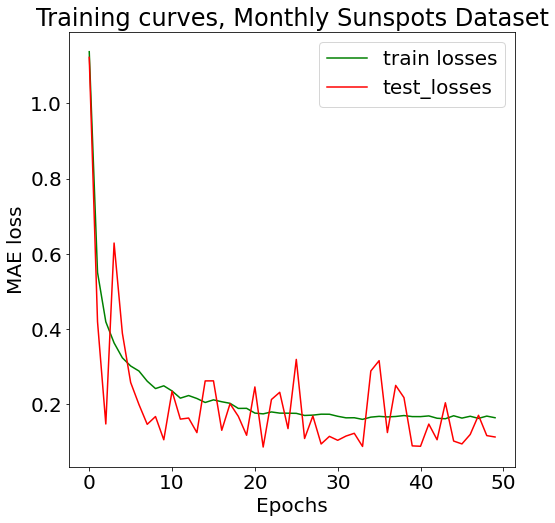

In [230]:
plt.figure(figsize = (8,8))

plt.plot(train_losses, label = 'train losses', color = 'green')
plt.plot(test_losses, label = 'test_losses', color = 'red')
plt.legend(loc = 'best')

plt.title('Training curves, Monthly Sunspots Dataset')

plt.xlabel('Epochs')
plt.ylabel('MAE loss')

plt.show()

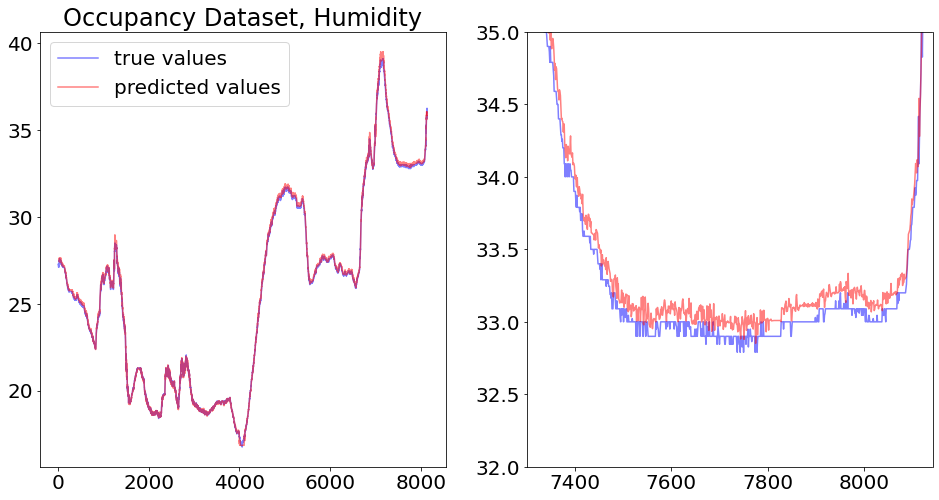

In [231]:
model.eval()
prediction_segment = torch.Tensor(train_test_data[0][:sizes[0]]).to(device)
absolute_prediction = model(prediction_segment).cpu().detach().numpy()

val_prediction_segment = torch.Tensor(validation_data[0]).to(device)
val_absolute_prediction = model(val_prediction_segment).cpu().detach().numpy()

fig, axes = plt.subplots(1, 2, figsize = (16, 8))
axes[0].plot(sync_data_hum, color = 'blue', label = 'true values', alpha = 0.5)
axes[0].plot(np.arange(m - sizes[0] + 1, m+1), absolute_prediction, color = 'red', label = 'predicted values', alpha = 0.5)
axes[0].plot(np.arange(m+1, m+11), val_absolute_prediction, color = 'red', alpha = 0.5)
axes[0].set_title('Occupancy Dataset, Humidity')
axes[0].legend(loc = 'best')


axes[1].plot(sync_data_hum, color = 'blue', label = 'true values', alpha = 0.5)
axes[1].plot(np.arange(m - sizes[0] + 1, m+1), absolute_prediction, color = 'red', label = 'predicted values', alpha = 0.5)
axes[1].plot(np.arange(m+1, m+11), val_absolute_prediction, color = 'red', alpha = 0.5)
#axes[1].set_title('Occupancy Dataset, Humidity')
axes[0].legend(loc = 'best')
axes[1].set_ylim(32, 35)
axes[1].set_xlim(7300, 8142)
plt.show()

In [239]:
sin(2*pi/5)

0.9510565162951535